# Question 2

Which Actor Traits Correspond to Specific Archetypes?\
Which actor traits — such as age, gender, ethnicity, and other physical attributes — are typically associated with specific archetypes? For instance, are certain traits more frequently linked to roles like heroes, villains, or mentors? Investigating these correlations can reveal patterns in casting decisions.

In [1]:
# ignore
%load_ext autoreload
%autoreload 2

In [2]:
# ignore
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [3]:
# ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../visualization"))
from plot_3d_like import plot_2d_heatmap

In [4]:
# ignore
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(str)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

The specific feature value affects archetype, if the probability to play a character with this archetype differs significantly between an actor with fixed feature value and an actor with no fixed value. It means that if $P(Archetype)$ differs significantly from $P(Archetype|Feature)$.\

The heatmap below represents $P(Archetype|Feature) - P(Archetype)$. The blue color is for the negative values, the orange color is for the positive ones, and `NSS` (Not Statistically Significant).

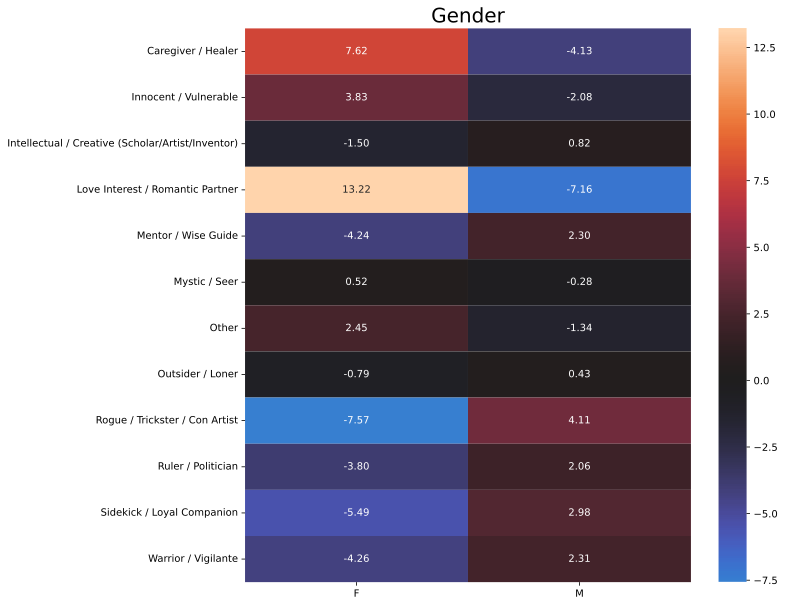

In [5]:
# hidecode

plt.figure(figsize=(1 * 10, 1 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_gender"],
    ["Gender"],
)):
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
        num_ybins=13,
        mht=True,
        do_not_show_x=["Other"] if title in ["Education", "Gender"] else None,
    )

Conditioning on `Gender` reveals a striking pattern: when the probability of playing a specific archetype increases for `Female` actors, it correspondingly decreases for `Male` actors, and vice versa. This asymmetry underscores how men and women are differently positioned within cinematic narratives, highlighting potential biases in how directors and screenwriters envision characters based on gender. The implications are profound, as the film industry not only reflects societal norms but actively shapes them. The figure illustrates this bias vividly, with the most significant differences observed in archetypes such as `Love Interest/Romantic Partner` (Female +13%, Male -7%), `Caregiver / Healer` (Female +7%, Male -4%), `Rogue / Trickster / Con Artist` (Female -7%, Male +4%), and `Sidekick / Local Companion` (Female -5%, Male +3%). Our dataset has films only until 2017, so there is a hope that this situation is different now.

The heatmaps below represents the difference between distribution if we condition on features which are closely related to `Race`: `Race`, `Religion`, `Nationality`, `Place of Birth`.

- Conditioning on `Race` shows that probability to play `Love Interest/Romantic Partner` significanlty increasese for `Indian` (+11%), `Asian`(+9%), `Latino` (+5%), and `Arab` (+13%) and decreases for `African` (-5%). Probably the number of Turkish melodrama does change the usual distribution :) The probability to play `Rogue / Trickster / Con Artist` are increases if an actor is `Middle Eastern` (+7%), and decreases if the actor is `Indigenous / Native American`. 

- Conditioning on `Education` doesn't show very significant changes in probability. 

- Conditioning on `Religion` shows a high dramatic increase of the probability to play `Warrior / Vigilante` for `Buddish` and `Hinduism` (almost +10%). Usually those religions are take place in `Asia` and `India`, so we can see the connection between the cultures in movies. Another interesting thing is that there is increase in probability to play this role for races `Indian` and `Asian` actors, but in a smaller way (+3% and +6%) and for nationalities `Japan` and `Indian`

- Conditioning on `Nationality` shows a significant decrease for `Japan` and (-8%). One also can notice a very high increase to play `Love Interest/Romantic Partner` for `Indian` actors (+13%). And even more, for actors who were born in Mumbai the probability of the same event increase on 22%. 

- Another interesting observation shows that the probability to play `Rogue / Trickster / Con Artist` increases on 20% for actos who were born in `San Francisco`.



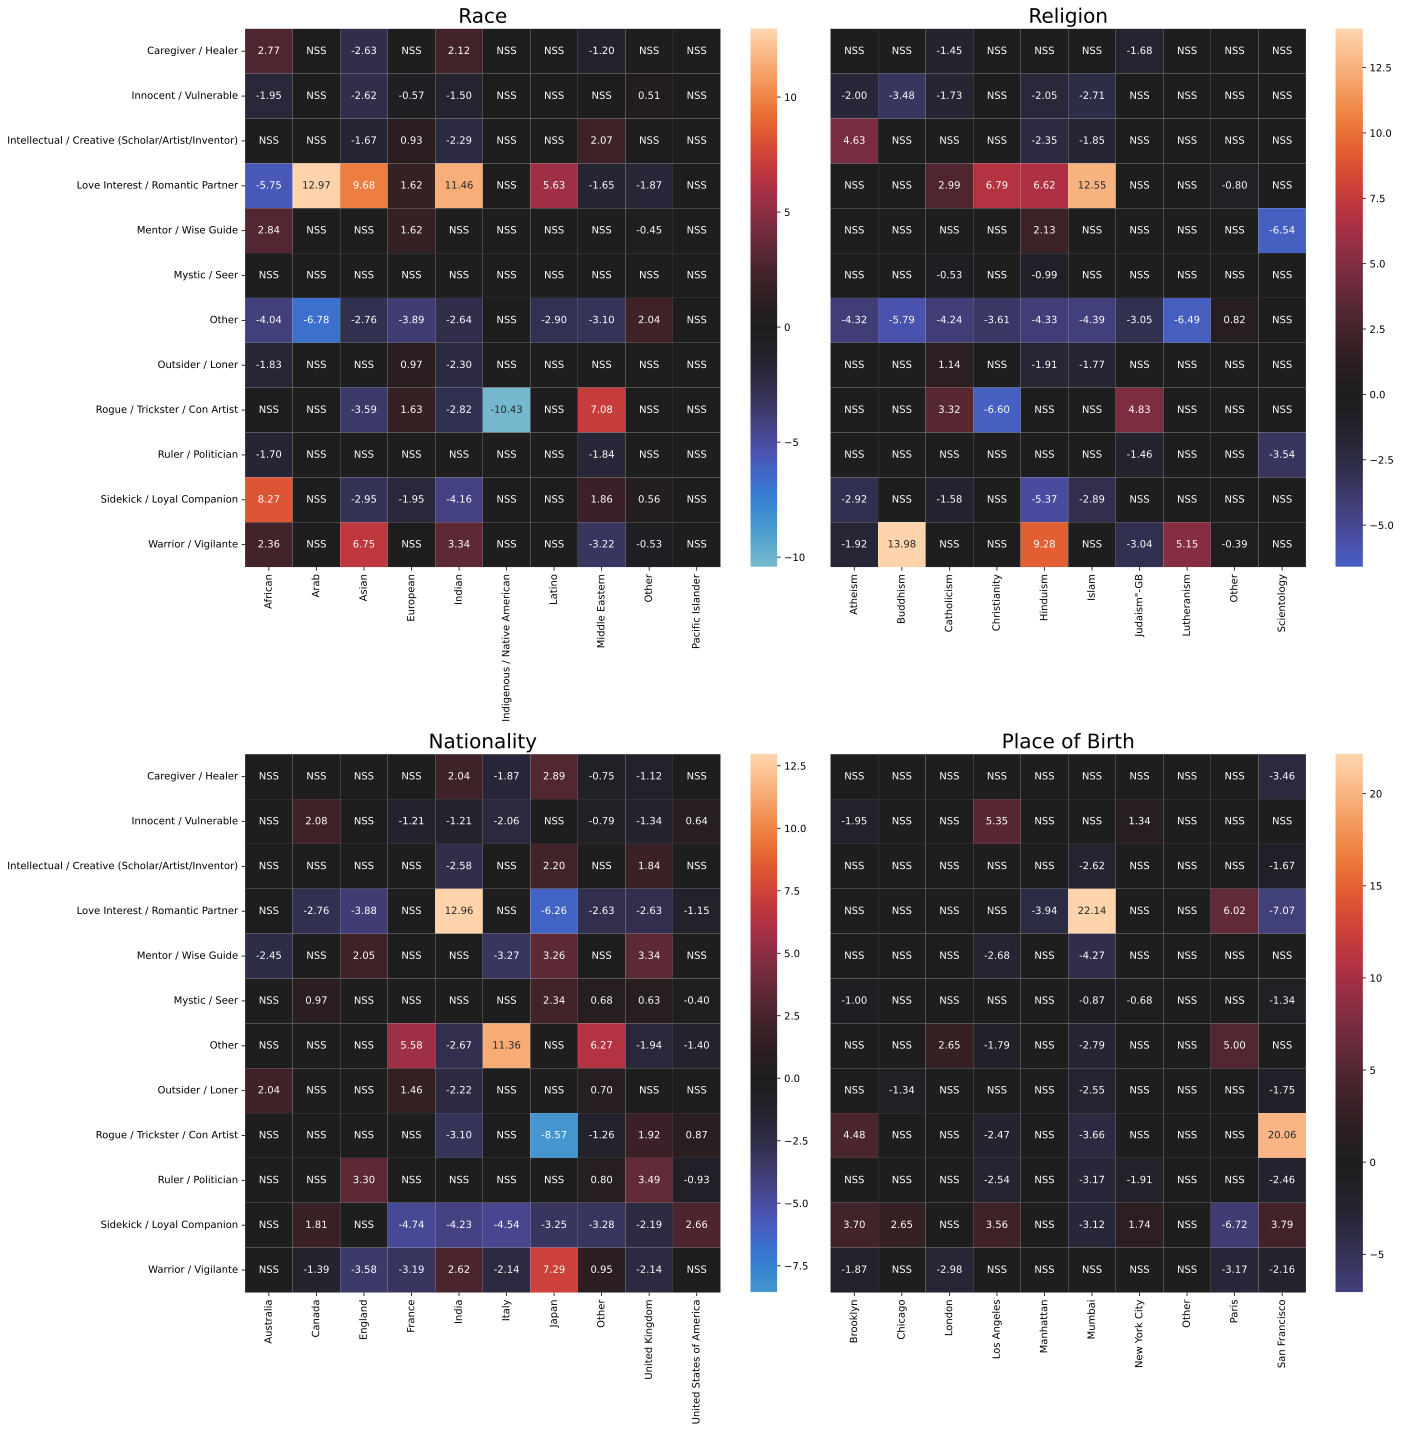

In [6]:
# hidecode

plt.figure(figsize=(2 * 10, 2 * 10))
for i, (s, title) in enumerate(zip(
    ["race", "religion", "nationality", "place_of_birth"],
    ["Race", "Religion", "Nationality", "Place of Birth"],
)):
    plt.subplot(2, 2, i + 1)
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
        num_ybins=13,
        mht=True,
    )
    if not i in [0, 2]:
        plt.yticks([])
plt.tight_layout()

- Conditioning on `Race` shows that probability to play `Love Interest/Romantic Partner` significanlty increasese for `Indian` (+11%), `Asian`(+9%), `Latino` (+5%), and `Arab` (+13%) and decreases for `African` (-5%). Probably the number of Turkish melodrama does change the usual distribution. The probability to play `Rogue / Trickster / Con Artist` are increases if an actor is `Middle Eastern` (+7%), and decreases if the actor is `Indigenous / Native American`. 

- Conditioning on `Education` doesn't show very significant changes in probability. 

- Conditioning on `Religion` shows a high dramatic increase of the probability to play `Warrior / Vigilante` for `Buddish` and `Hinduism` (almost +10%). Usually those religions are take place in `Asia` and `India`, so we can see the connection between the cultures in movies. Another interesting thing is that there is increase in probability to play this role for races `Indian` and `Asian` actors, but in a smaller way (+3% and +6%) and for nationalities `Japan` and `Indian`

- Conditioning on `Nationality` shows a significant decrease for `Japan` and (-8%). One also can notice a very high increase to play `Love Interest/Romantic Partner` for `Indian` actors (+13%). And even more, for actors who were born in Mumbai the probability of the same event increase on 22%. 

- Another interesting observation shows that the probability to play `Rogue / Trickster / Con Artist` increases on 20% for actos who were born in `San Francisco`.



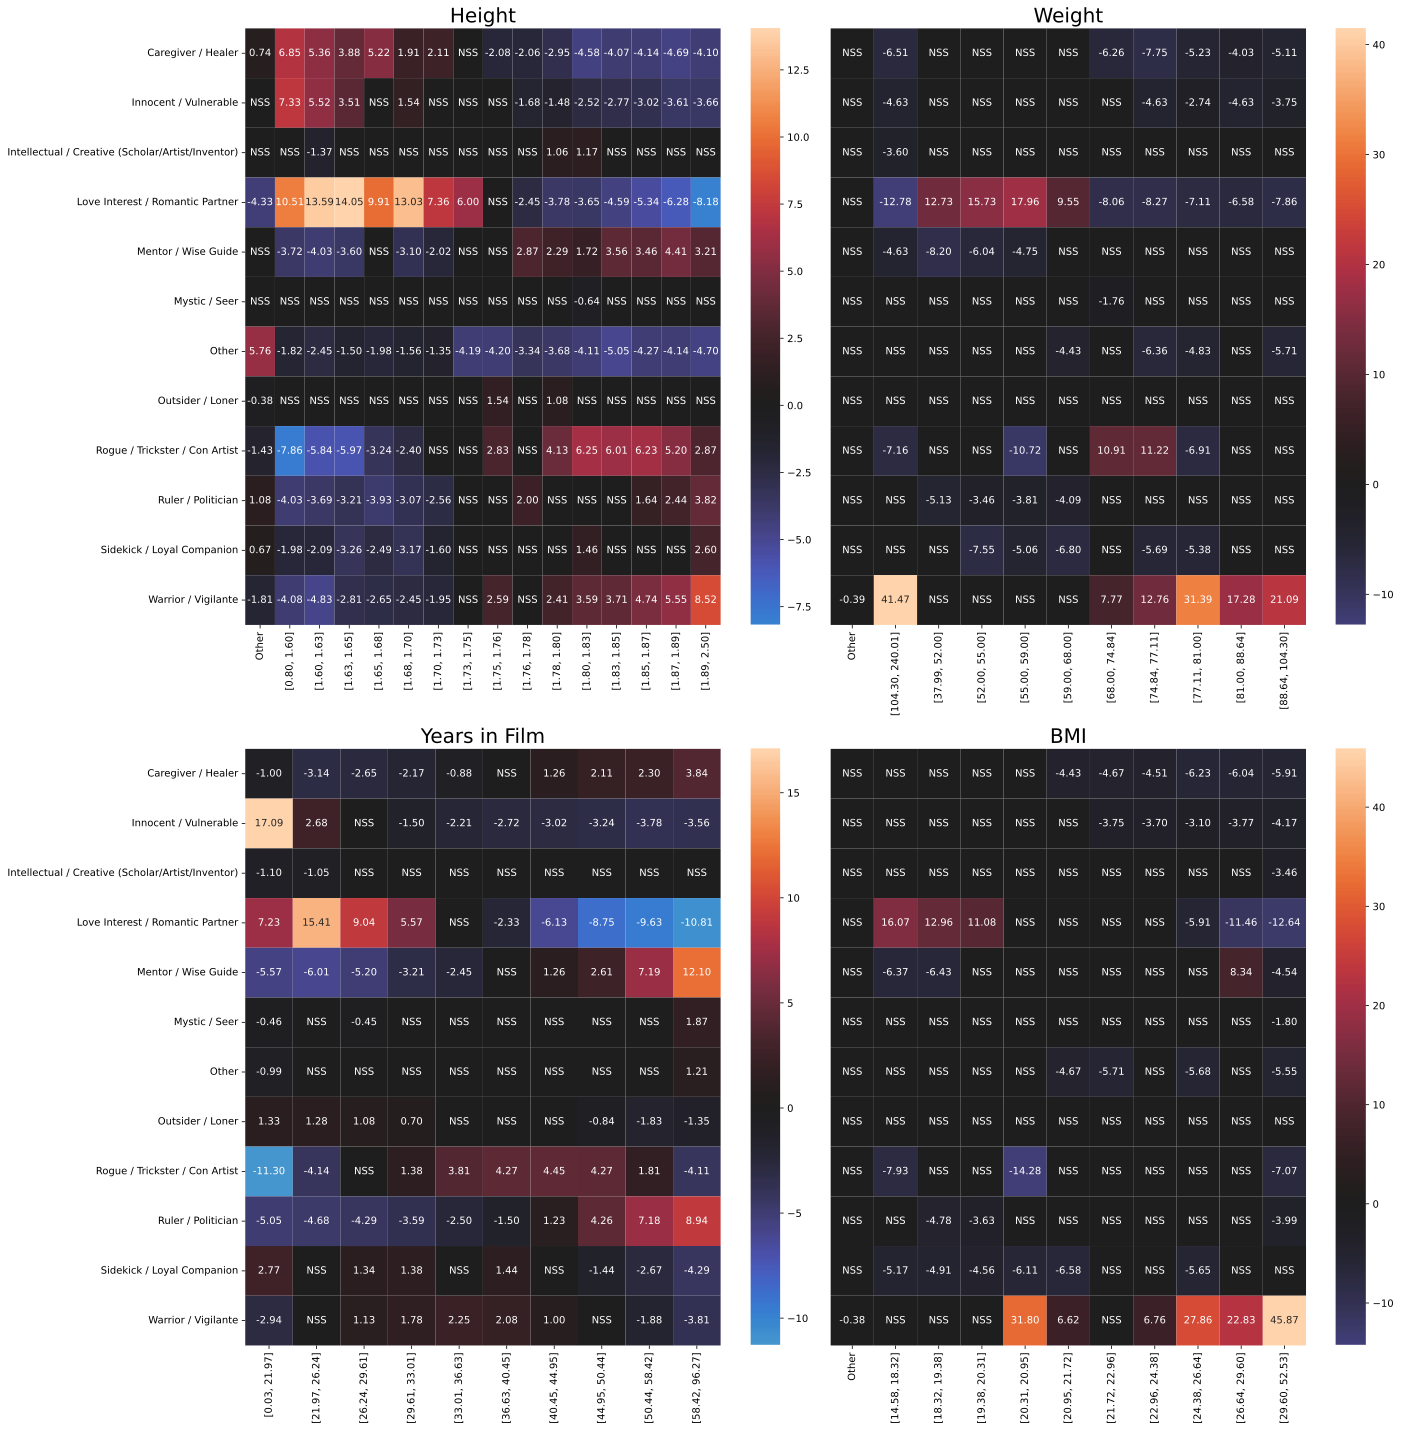

In [9]:
# hidecode

plt.figure(figsize=(2 * 10, 2 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_height", "weight", "years_in_film", "actor_bmi"],
    ["Height", "Weight", "Years in Film", "BMI"],
)):
    plt.subplot(2, 2, i + 1)
        
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
        num_ybins=13,
        num_xbins = 15 if title == "Height" else 10,
        mht=True
    )
    if not i in [0, 2]:
        plt.yticks([])
plt.tight_layout()

# python pages/merger.py \
#                   src/story/Question_2.ipynb \
#                   src/story/Question_3.ipynb \
#                   > pages/merged.ipynb
# python pages/render.py pages/merged.ipynb > pages/index.markdown


This figure represents $P(Archetype|Feature) - P(Archetype)$ for numerical features. The bins are sampled such that the **probability** of each bin is uniform, i.e. we $\text{bin}_i$ represents $[\operatorname{quantile}(\frac{i}{n}), \operatorname{quantile}(\frac{i}{n + 1})]$. The blue color is for the negative values, and the orange is for the positive ones, and `NSS` means that the difference is not significant. \

- Conditioning on `Height` shows that the probability to play `Love Interest / Romantic Partner` (by 14% at max), `Innocent / Vulnerable` (by 7% at max), and `Caregiver / Healer` (by 7% at max) are higher for lower people. More suprisingly, the probability firstly **monotonically** increases until some height, and then start to decrease also **monotonically**. Even more surprisingly is that the height for the maximum heigh are different for `Love Interest / Romantic Partner` and `Caregiver / Healer`, but they are close (difference is < 3 cm). One can also notice that if an actor is high tall then it has more changes to play `Mentor / Wise Guide` (by 4% at 188cm) `Rogue / Trickster / Con Artist` (by 6% at 180cm) and `Warrior / Vigilante` (by 8% at 190cm). And if an actor is low then it has less chances to play a politician.

- Conditioning on `Weight` shows that for the same law for `Love Interest / Romantic Partner` --- it firstly increases and then decreases. The maximum is +18% at 57 kg. The law for `Warrior / Vigilante` is that the probability increases **monotonically** with weight and has maximum of +41% for people who weight 105+ kg. it seems that it is difficult to imagine people with big weight as `Love Interest / Romantic Partner` but more like a `Warrior`.

- Conditioning on `Age` of the actor shows that the probability to play `Innocent / Vulnerable` increases if the actor is young and monotonically decreases with age. The logical but interesting observation is that if when the actor is old then the probability to play `Mentor / Wise Guide` is higher. And this sounds super logical, because in our everyday life adults usually wiser. Okay, at least they look wiser. Additionally, the probability to play `Ruler / Politician` is higher if when the actor is older. It sounds logical too, because in our everyday life politicians are adults. The probability to play `Love Interest / Romantic Partner` has the same behaviour as for conditioning this archetype on `Height`.

- Conditioning on `BMI` shows that the chances to play `Love Interest / Romantic Partner` have the same law as for `height` -- lower is more probable. Another interesting observation is the increase probability for `Warrior / Vigilante` has two maxima. The first is at ~21 BMI and the second is at ~29+ BMI.